# 🏗️ Pipeline ELT - Dados ITBI Recife 2023-2025

**Projeto de Integração de Dados**  
**ELT = Extract → Load → Transform**

---

## 📋 Objetivo
Implementar um pipeline ELT completo para integrar dados do ITBI (Imposto sobre Transmissão de Bens Imóveis) da cidade do Recife dos anos 2023, 2024 e 2025.

## 🔄 Diferença ETL vs ELT:
- **ETL**: Extract → Transform → Load (transforma antes de carregar)
- **ELT**: Extract → Load → Transform (carrega dados brutos, transforma no banco)

## 📊 Fontes de Dados:
- Portal de Dados Abertos do Recife
- Datasets ITBI 2023, 2024, 2025
- Formato: CSV com separador ';'

In [6]:

# Imports
import pandas as pd
import sqlite3
import requests
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('default')
sns.set_palette("husl")

print("✅ Dependências instaladas e configuradas!")
print(f"📅 Execução iniciada em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Dependências instaladas e configuradas!
📅 Execução iniciada em: 2025-07-29 13:51:05


## 📥 2. EXTRACT - Extração de Dados Brutos

No pipeline ELT, extraímos os dados em seu formato original, sem aplicar transformações.

In [7]:
def extract_itbi_data_elt():
    """
    Extrai dados ITBI dos 3 anos para o pipeline ELT.
    No ELT, extraímos os dados brutos sem transformações.
    """
    
    # URLs dos datasets oficiais
    datasets_urls = [
        ("2023", "http://dados.recife.pe.gov.br/dataset/28e3e25e-a9a7-4a9f-90a8-bb02d09cbc18/resource/d0c08a6f-4c27-423c-9219-8d13403816f4/download/itbi_2023.csv"),
        ("2024", "http://dados.recife.pe.gov.br/dataset/28e3e25e-a9a7-4a9f-90a8-bb02d09cbc18/resource/a36d548b-d705-496a-ac47-4ec36f068474/download/itbi_2024.csv"),
        ("2025", "http://dados.recife.pe.gov.br/dataset/28e3e25e-a9a7-4a9f-90a8-bb02d09cbc18/resource/5b582147-3935-459a-bbf7-ee623c22c97b/download/itbi_2025.csv")
    ]
    
    datasets_dict = {}
    total_records = 0
    
    print("📥 INICIANDO EXTRAÇÃO DOS DADOS - PIPELINE ELT")
    print("-" * 45)
    print("🔍 No ELT, extraímos dados BRUTOS sem transformações")
    
    for year, url in datasets_urls:
        print(f"\n📅 Extraindo dados brutos ITBI {year}...")
        
        try:
            # Carregar dados SEM transformações (dados brutos)
            df = pd.read_csv(url, sep=';', encoding='utf-8')
            
            # Apenas adicionar metadados mínimos
            df['source_year'] = year
            df['extraction_timestamp'] = datetime.now()
            df['pipeline_type'] = 'ELT'
            
            # Validação básica
            if df.empty:
                raise ValueError(f"Dataset {year} está vazio")
            
            # Armazenar dataset bruto
            datasets_dict[year] = df
            total_records += len(df)
            
            print(f"   ✅ Dados brutos extraídos: {len(df):,} registros")
            print(f"   📊 Colunas originais: {len(df.columns)}")
            print(f"   📝 Nenhuma transformação aplicada")
            
        except Exception as e:
            print(f"   ❌ Erro extraindo {year}: {e}")
            continue
    
    print(f"\n✅ Extração ELT concluída:")
    print(f"   • Datasets extraídos: {len(datasets_dict)}")
    print(f"   • Total de registros brutos: {total_records:,}")
    print(f"   • Próximo passo: LOAD (carregar no banco)")
    
    return datasets_dict

# Executar extração
datasets_raw = extract_itbi_data_elt()

# Mostrar amostras dos dados brutos
print("\n🔍 AMOSTRA DOS DADOS BRUTOS:")
for year, df in datasets_raw.items():
    print(f"\n📅 Dataset {year}:")
    print(f"   • Shape: {df.shape}")
    print(f"   • Colunas: {list(df.columns[:10])}...")  # Primeiras 10 colunas
    print(f"   • Tipos de dados: {df.dtypes.value_counts().to_dict()}")
    print(f"   • Valores nulos: {df.isnull().sum().sum()}")

📥 INICIANDO EXTRAÇÃO DOS DADOS - PIPELINE ELT
---------------------------------------------
🔍 No ELT, extraímos dados BRUTOS sem transformações

📅 Extraindo dados brutos ITBI 2023...
   ✅ Dados brutos extraídos: 12,669 registros
   📊 Colunas originais: 25
   📝 Nenhuma transformação aplicada

📅 Extraindo dados brutos ITBI 2024...
   ✅ Dados brutos extraídos: 15,242 registros
   📊 Colunas originais: 25
   📝 Nenhuma transformação aplicada

📅 Extraindo dados brutos ITBI 2025...
   ✅ Dados brutos extraídos: 7,206 registros
   📊 Colunas originais: 25
   📝 Nenhuma transformação aplicada

✅ Extração ELT concluída:
   • Datasets extraídos: 3
   • Total de registros brutos: 35,117
   • Próximo passo: LOAD (carregar no banco)

🔍 AMOSTRA DOS DADOS BRUTOS:

📅 Dataset 2023:
   • Shape: (12669, 25)
   • Colunas: ['logradouro', 'numero', 'complemento', 'valor_avaliacao', 'bairro', 'cidade', 'uf', 'ano_construcao', 'area_terreno', 'area_construida']...
   • Tipos de dados: {dtype('O'): 18, dtype('int64

## 💾 3. LOAD - Carregamento no Banco de Dados

No ELT, carregamos os dados brutos diretamente no banco, sem transformações.

In [9]:
def create_database_schema(db_path):
    """Cria o schema do banco de dados para dados brutos."""
    
    print("🗄️ Criando schema do banco de dados...")
    
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Tabela para dados brutos (schema flexível)
    create_raw_table = """
    CREATE TABLE IF NOT EXISTS itbi_raw (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        -- Dados originais (como texto para preservar formato original)
        valor_avaliacao TEXT,
        bairro TEXT,
        tipo_imovel TEXT,
        data_transacao TEXT,
        logradouro TEXT,
        numero TEXT,
        complemento TEXT,
        cep TEXT,
        area_terreno TEXT,
        area_construida TEXT,
        ano_construcao TEXT,
        fracao_ideal TEXT,
        valores_financiados_sfh TEXT,
        
        -- Metadados de carregamento
        source_year TEXT,
        extraction_timestamp TEXT,
        pipeline_type TEXT,
        load_timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
    );
    """
    
    # Tabela de metadados do carregamento
    create_metadata_table = """
    CREATE TABLE IF NOT EXISTS load_metadata (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        load_timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
        source_year TEXT,
        records_loaded INTEGER,
        pipeline_type TEXT,
        status TEXT
    );
    """
    
    # Executar criação das tabelas
    cursor.execute(create_raw_table)
    cursor.execute(create_metadata_table)
    
    # Criar índices para performance
    cursor.execute("CREATE INDEX IF NOT EXISTS idx_source_year ON itbi_raw(source_year);")
    cursor.execute("CREATE INDEX IF NOT EXISTS idx_bairro ON itbi_raw(bairro);")
    
    conn.commit()
    conn.close()
    
    print("   ✅ Schema criado com sucesso!")

# Criar schema
create_database_schema("itbi_datawarehouse.db")

🗄️ Criando schema do banco de dados...
   ✅ Schema criado com sucesso!


In [10]:
def load_raw_datasets(datasets_dict, db_path):
    """Carrega todos os datasets brutos no banco."""
    
    print("\n💾 CARREGANDO DADOS BRUTOS NO BANCO - PIPELINE ELT")
    print("-" * 50)
    
    load_results = {}
    total_loaded = 0
    
    conn = sqlite3.connect(db_path)
    
    for year, df in datasets_dict.items():
        print(f"\n📥 Carregando dados brutos {year} no banco...")
        
        try:
            # Limpar dados existentes do ano
            conn.execute("DELETE FROM itbi_raw WHERE source_year = ?", (year,))
            
            # Preparar dados para inserção (manter como texto)
            df_to_load = df.copy()
            
            # Converter todas as colunas para string para preservar formato original
            for col in df_to_load.columns:
                if col not in ['source_year', 'extraction_timestamp', 'pipeline_type']:
                    df_to_load[col] = df_to_load[col].astype(str)
            
            # Carregar para o banco
            df_to_load.to_sql('itbi_raw', conn, if_exists='append', index=False)
            
            records_loaded = len(df_to_load)
            load_results[year] = records_loaded
            total_loaded += records_loaded
            
            # Registrar metadados
            metadata = {
                'source_year': year,
                'records_loaded': records_loaded,
                'pipeline_type': 'ELT',
                'status': 'success'
            }
            
            pd.DataFrame([metadata]).to_sql('load_metadata', conn, if_exists='append', index=False)
            
            print(f"   ✅ {records_loaded:,} registros carregados com sucesso")
            
        except Exception as e:
            print(f"   ❌ Erro carregando {year}: {e}")
            load_results[year] = 0
    
    conn.commit()
    conn.close()
    
    print(f"\n✅ Carregamento concluído:")
    print(f"   • Total de registros carregados: {total_loaded:,}")
    print(f"   • Datasets processados: {len(load_results)}")
    print(f"   • Próximo passo: TRANSFORM (transformações no banco)")
    
    return load_results

# Executar carregamento
db_path = "itbi_datawarehouse.db"
load_results = load_raw_datasets(datasets_raw, db_path)

# Verificar dados carregados
conn = sqlite3.connect(db_path)
verification_query = "SELECT source_year, COUNT(*) as count FROM itbi_raw GROUP BY source_year ORDER BY source_year"
verification_df = pd.read_sql_query(verification_query, conn)
conn.close()

print("\n🔍 VERIFICAÇÃO DOS DADOS CARREGADOS:")
print(verification_df)


💾 CARREGANDO DADOS BRUTOS NO BANCO - PIPELINE ELT
--------------------------------------------------

📥 Carregando dados brutos 2023 no banco...
   ❌ Erro carregando 2023: table itbi_raw has no column named cidade

📥 Carregando dados brutos 2024 no banco...
   ❌ Erro carregando 2024: table itbi_raw has no column named cidade

📥 Carregando dados brutos 2025 no banco...
   ❌ Erro carregando 2025: table itbi_raw has no column named cidade

✅ Carregamento concluído:
   • Total de registros carregados: 0
   • Datasets processados: 3
   • Próximo passo: TRANSFORM (transformações no banco)

🔍 VERIFICAÇÃO DOS DADOS CARREGADOS:
Empty DataFrame
Columns: [source_year, count]
Index: []


## 🔄 4. TRANSFORM - Transformações no Banco de Dados

No ELT, as transformações são executadas diretamente no banco de dados após o carregamento.

In [12]:
def create_flexible_database_schema(db_path, datasets_dict):
    """Cria schema flexível baseado nas colunas reais dos dados."""
    
    print("🗄️ Criando schema flexível do banco de dados...")
    
    # Coletar todas as colunas únicas dos datasets
    all_columns = set()
    for year, df in datasets_dict.items():
        all_columns.update(df.columns.tolist())
    
    # Remover colunas de metadados que já estão definidas
    data_columns = all_columns - {'source_year', 'extraction_timestamp', 'pipeline_type'}
    
    print(f"   📊 Colunas encontradas nos dados: {len(data_columns)}")
    print(f"   📝 Algumas colunas: {list(data_columns)[:10]}...")
    
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Deletar tabela existente se houver
    cursor.execute("DROP TABLE IF EXISTS itbi_raw")
    cursor.execute("DROP TABLE IF EXISTS load_metadata")
    
    # Criar definição de colunas dinamicamente
    column_definitions = []
    for col in sorted(data_columns):
        # Limpar nome da coluna (remover caracteres especiais)
        clean_col = col.replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '')
        column_definitions.append(f"[{clean_col}] TEXT")
    
    # Tabela para dados brutos (schema flexível)
    create_raw_table = f"""
    CREATE TABLE IF NOT EXISTS itbi_raw (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        
        -- Colunas dos dados originais
        {', '.join(column_definitions)},
        
        -- Metadados de carregamento
        source_year TEXT,
        extraction_timestamp TEXT,
        pipeline_type TEXT,
        load_timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
    );
    """
    
    # Tabela de metadados do carregamento
    create_metadata_table = """
    CREATE TABLE IF NOT EXISTS load_metadata (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        load_timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
        source_year TEXT,
        records_loaded INTEGER,
        pipeline_type TEXT,
        status TEXT
    );
    """
    
    # Executar criação das tabelas
    cursor.execute(create_raw_table)
    cursor.execute(create_metadata_table)
    
    # Criar índices para performance
    cursor.execute("CREATE INDEX IF NOT EXISTS idx_source_year ON itbi_raw(source_year);")
    
    conn.commit()
    conn.close()
    
    print("   ✅ Schema flexível criado com sucesso!")
    return sorted(data_columns)

# Recriar schema com base nos dados reais
data_columns = create_flexible_database_schema(db_path, datasets_raw)

🗄️ Criando schema flexível do banco de dados...
   📊 Colunas encontradas nos dados: 22
   📝 Algumas colunas: ['sfh', 'complemento', 'padrao_acabamento', 'area_terreno', 'tipo_ocupacao', 'logradouro', 'valor_avaliacao', 'cod_logradouro', 'tipo_construcao', 'numero']...
   ✅ Schema flexível criado com sucesso!


In [13]:
def load_raw_datasets_flexible(datasets_dict, db_path):
    """Carrega todos os datasets brutos no banco com schema flexível."""
    
    print("\n💾 CARREGANDO DADOS BRUTOS NO BANCO - PIPELINE ELT (FLEXÍVEL)")
    print("-" * 60)
    
    load_results = {}
    total_loaded = 0
    
    conn = sqlite3.connect(db_path)
    
    for year, df in datasets_dict.items():
        print(f"\n📥 Carregando dados brutos {year} no banco...")
        
        try:
            # Preparar dados para inserção
            df_to_load = df.copy()
            
            # Limpar nomes das colunas (mesmo processo do schema)
            df_to_load.columns = [
                col.replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '') 
                for col in df_to_load.columns
            ]
            
            # Converter todas as colunas para string para preservar formato original
            for col in df_to_load.columns:
                if col not in ['source_year', 'extraction_timestamp', 'pipeline_type']:
                    df_to_load[col] = df_to_load[col].astype(str)
            
            # Limpar dados existentes do ano
            conn.execute("DELETE FROM itbi_raw WHERE source_year = ?", (year,))
            
            # Carregar para o banco
            df_to_load.to_sql('itbi_raw', conn, if_exists='append', index=False)
            
            records_loaded = len(df_to_load)
            load_results[year] = records_loaded
            total_loaded += records_loaded
            
            # Registrar metadados
            metadata = {
                'source_year': year,
                'records_loaded': records_loaded,
                'pipeline_type': 'ELT',
                'status': 'success'
            }
            
            pd.DataFrame([metadata]).to_sql('load_metadata', conn, if_exists='append', index=False)
            
            print(f"   ✅ {records_loaded:,} registros carregados com sucesso")
            print(f"   📊 Colunas carregadas: {len(df_to_load.columns)}")
            
        except Exception as e:
            print(f"   ❌ Erro carregando {year}: {e}")
            load_results[year] = 0
            
            # Registrar erro nos metadados
            error_metadata = {
                'source_year': year,
                'records_loaded': 0,
                'pipeline_type': 'ELT',
                'status': f'error: {str(e)}'
            }
            
            pd.DataFrame([error_metadata]).to_sql('load_metadata', conn, if_exists='append', index=False)
    
    conn.commit()
    conn.close()
    
    print(f"\n✅ Carregamento concluído:")
    print(f"   • Total de registros carregados: {total_loaded:,}")
    print(f"   • Datasets processados: {len(load_results)}")
    
    if total_loaded > 0:
        print(f"   • Próximo passo: TRANSFORM (transformações no banco)")
    else:
        print(f"   ⚠️ Nenhum registro foi carregado. Verifique os erros acima.")
    
    return load_results

# Executar carregamento corrigido
load_results = load_raw_datasets_flexible(datasets_raw, db_path)

# Verificar dados carregados
conn = sqlite3.connect(db_path)
try:
    verification_query = "SELECT source_year, COUNT(*) as count FROM itbi_raw GROUP BY source_year ORDER BY source_year"
    verification_df = pd.read_sql_query(verification_query, conn)
    
    print("\n🔍 VERIFICAÇÃO DOS DADOS CARREGADOS:")
    if len(verification_df) > 0:
        print(verification_df)
        
        # Mostrar algumas colunas da tabela
        columns_query = "PRAGMA table_info(itbi_raw)"
        columns_df = pd.read_sql_query(columns_query, conn)
        print(f"\n📋 Total de colunas na tabela: {len(columns_df)}")
        print(f"📝 Primeiras colunas: {columns_df['name'].head(10).tolist()}")
    else:
        print("❌ Nenhum dado foi carregado no banco.")
        
except Exception as e:
    print(f"❌ Erro verificando dados: {e}")
finally:
    conn.close()


💾 CARREGANDO DADOS BRUTOS NO BANCO - PIPELINE ELT (FLEXÍVEL)
------------------------------------------------------------

📥 Carregando dados brutos 2023 no banco...
   ✅ 12,669 registros carregados com sucesso
   📊 Colunas carregadas: 25

📥 Carregando dados brutos 2024 no banco...
   ✅ 15,242 registros carregados com sucesso
   📊 Colunas carregadas: 25

📥 Carregando dados brutos 2025 no banco...
   ✅ 7,206 registros carregados com sucesso
   📊 Colunas carregadas: 25

✅ Carregamento concluído:
   • Total de registros carregados: 35,117
   • Datasets processados: 3
   • Próximo passo: TRANSFORM (transformações no banco)

🔍 VERIFICAÇÃO DOS DADOS CARREGADOS:
  source_year  count
0        2023  12669
1        2024  15242
2        2025   7206

📋 Total de colunas na tabela: 27
📝 Primeiras colunas: ['id', 'ano', 'ano_construcao', 'area_construida', 'area_terreno', 'bairro', 'cidade', 'cod_logradouro', 'complemento', 'data_transacao']


In [14]:
def create_transformed_tables_schema_updated(db_path):
    """Cria schema das tabelas transformadas baseado nas colunas reais."""
    
    print("🏗️ Criando schema das tabelas transformadas...")
    
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Deletar tabela transformada existente se houver
    cursor.execute("DROP TABLE IF EXISTS itbi_transformed")
    
    # Tabela principal transformada com base nas colunas encontradas
    create_transformed_table = """
    CREATE TABLE IF NOT EXISTS itbi_transformed (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        
        -- Dados transformados e tipados (baseados nas colunas reais)
        valor_avaliacao REAL,
        valor_por_m2 REAL,
        bairro TEXT,
        tipo_imovel TEXT,
        data_transacao DATE,
        ano_transacao INTEGER,
        mes_transacao INTEGER,
        trimestre INTEGER,
        
        logradouro TEXT,
        numero TEXT,
        complemento TEXT,
        cep TEXT,
        cidade TEXT,
        
        area_terreno REAL,
        area_construida REAL,
        ano_construcao INTEGER,
        idade_imovel INTEGER,
        fracao_ideal REAL,
        
        -- Valores financeiros
        sfh REAL,
        tem_financiamento BOOLEAN,
        
        -- Métricas derivadas
        faixa_valor TEXT,
        categoria_area TEXT,
        periodo_construcao TEXT,
        
        -- Metadados
        source_year TEXT,
        transformation_timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
        pipeline_type TEXT DEFAULT 'ELT'
    );
    """
    
    cursor.execute(create_transformed_table)
    
    # Criar índices
    indices = [
        "CREATE INDEX IF NOT EXISTS idx_transformed_year ON itbi_transformed(source_year);",
        "CREATE INDEX IF NOT EXISTS idx_transformed_bairro ON itbi_transformed(bairro);",
        "CREATE INDEX IF NOT EXISTS idx_transformed_valor ON itbi_transformed(valor_avaliacao);",
        "CREATE INDEX IF NOT EXISTS idx_transformed_data ON itbi_transformed(data_transacao);"
    ]
    
    for index in indices:
        cursor.execute(index)
    
    conn.commit()
    conn.close()
    
    print("   ✅ Schema das tabelas transformadas criado!")

# Criar schema transformado atualizado
create_transformed_tables_schema_updated(db_path)

🏗️ Criando schema das tabelas transformadas...
   ✅ Schema das tabelas transformadas criado!


In [16]:
# Verificar colunas reais disponíveis na tabela
conn = sqlite3.connect(db_path)

print("🔍 VERIFICANDO COLUNAS DISPONÍVEIS:")
print("-" * 40)

# Obter informações das colunas
columns_query = "PRAGMA table_info(itbi_raw)"
columns_df = pd.read_sql_query(columns_query, conn)

print(f"📊 Total de colunas: {len(columns_df)}")
print("\n📋 Todas as colunas disponíveis:")
for i, col in enumerate(columns_df['name'], 1):
    print(f"   {i:2d}. {col}")

# Verificar uma amostra dos dados
print(f"\n🔍 AMOSTRA DOS DADOS (primeira linha):")
sample_query = "SELECT * FROM itbi_raw LIMIT 1"
sample_df = pd.read_sql_query(sample_query, conn)

for col in sample_df.columns:
    print(f"   {col}: {sample_df[col].iloc[0]}")

conn.close()

🔍 VERIFICANDO COLUNAS DISPONÍVEIS:
----------------------------------------
📊 Total de colunas: 27

📋 Todas as colunas disponíveis:
    1. id
    2. ano
    3. ano_construcao
    4. area_construida
    5. area_terreno
    6. bairro
    7. cidade
    8. cod_logradouro
    9. complemento
   10. data_transacao
   11. estado_conservacao
   12. fracao_ideal
   13. latitude
   14. logradouro
   15. longitude
   16. numero
   17. padrao_acabamento
   18. sfh
   19. tipo_construcao
   20. tipo_imovel
   21. tipo_ocupacao
   22. uf
   23. valor_avaliacao
   24. source_year
   25. extraction_timestamp
   26. pipeline_type
   27. load_timestamp

🔍 AMOSTRA DOS DADOS (primeira linha):
   id: 1
   ano: 2023
   ano_construcao: 1997
   area_construida: 511,0
   area_terreno: 438,0
   bairro: Encruzilhada
   cidade: Recife
   cod_logradouro: 46540
   complemento: nan
   data_transacao: 2023-12-21
   estado_conservacao: Regular
   fracao_ideal: 1,0
   latitude: -8.034273
   logradouro: av norte miguel a

In [18]:
def transform_data_with_available_columns(db_path):
    """Executa transformações usando apenas colunas que existem."""
    
    print("🔄 EXECUTANDO TRANSFORMAÇÕES COM COLUNAS DISPONÍVEIS")
    print("-" * 55)
    
    conn = sqlite3.connect(db_path)
    
    # Obter colunas disponíveis
    columns_query = "PRAGMA table_info(itbi_raw)"
    columns_df = pd.read_sql_query(columns_query, conn)
    available_columns = columns_df['name'].tolist()
    
    print(f"📊 Colunas disponíveis: {len(available_columns)}")
    
    # Mapear colunas disponíveis
    column_mapping = {}
    for col in available_columns:
        col_lower = col.lower()
        if 'valor' in col_lower and ('avalia' in col_lower or 'transac' in col_lower):
            column_mapping['valor_avaliacao'] = col
        elif 'bairro' in col_lower:
            column_mapping['bairro'] = col
        elif 'tipo' in col_lower and 'imovel' in col_lower:
            column_mapping['tipo_imovel'] = col
        elif 'data' in col_lower and 'transac' in col_lower:
            column_mapping['data_transacao'] = col
        elif 'logradouro' in col_lower:
            column_mapping['logradouro'] = col
        elif 'numero' in col_lower:
            column_mapping['numero'] = col
        elif 'complemento' in col_lower:
            column_mapping['complemento'] = col
        elif 'cidade' in col_lower:
            column_mapping['cidade'] = col
        elif 'area' in col_lower and 'terreno' in col_lower:
            column_mapping['area_terreno'] = col
        elif 'area' in col_lower and 'constru' in col_lower:
            column_mapping['area_construida'] = col
        elif 'ano' in col_lower and 'constru' in col_lower:
            column_mapping['ano_construcao'] = col
        elif 'fracao' in col_lower or 'ideal' in col_lower:
            column_mapping['fracao_ideal'] = col
        elif 'sfh' in col_lower:
            column_mapping['sfh'] = col
    
    print(f"📋 Mapeamento de colunas:")
    for key, value in column_mapping.items():
        print(f"   {key} -> {value}")
    
    # Obter anos disponíveis
    years_query = "SELECT DISTINCT source_year FROM itbi_raw ORDER BY source_year"
    available_years = pd.read_sql_query(years_query, conn)['source_year'].tolist()
    
    print(f"\n📅 Anos encontrados: {available_years}")
    
    transformation_results = {}
    
    for year in available_years:
        print(f"\n🔄 Transformando dados de {year} no banco...")
        
        try:
            # Construir SQL dinamicamente baseado nas colunas disponíveis
            select_parts = []
            insert_columns = []
            
            # Valor de avaliação
            if 'valor_avaliacao' in column_mapping:
                col = column_mapping['valor_avaliacao']
                select_parts.append(f"""
                    CASE 
                        WHEN [{col}] != 'nan' AND [{col}] != '' AND [{col}] IS NOT NULL 
                        THEN CAST(REPLACE(REPLACE([{col}], '.', ''), ',', '.') AS REAL)
                        ELSE NULL
                    END as valor_avaliacao
                """)
                insert_columns.append('valor_avaliacao')
            
            # Bairro
            if 'bairro' in column_mapping:
                col = column_mapping['bairro']
                select_parts.append(f"CASE WHEN [{col}] != 'nan' AND [{col}] != '' THEN TRIM([{col}]) ELSE NULL END as bairro")
                insert_columns.append('bairro')
            
            # Tipo de imóvel
            if 'tipo_imovel' in column_mapping:
                col = column_mapping['tipo_imovel']
                select_parts.append(f"CASE WHEN [{col}] != 'nan' AND [{col}] != '' THEN TRIM([{col}]) ELSE NULL END as tipo_imovel")
                insert_columns.append('tipo_imovel')
            
            # Data de transação
            if 'data_transacao' in column_mapping:
                col = column_mapping['data_transacao']
                select_parts.append(f"""
                    CASE 
                        WHEN [{col}] != 'nan' AND [{col}] != '' AND [{col}] IS NOT NULL
                        THEN DATE([{col}]) 
                        ELSE NULL 
                    END as data_transacao
                """)
                select_parts.append(f"""
                    CASE 
                        WHEN [{col}] != 'nan' AND [{col}] != '' AND [{col}] IS NOT NULL
                        THEN CAST(strftime('%Y', [{col}]) AS INTEGER)
                        ELSE NULL 
                    END as ano_transacao
                """)
                select_parts.append(f"""
                    CASE 
                        WHEN [{col}] != 'nan' AND [{col}] != '' AND [{col}] IS NOT NULL
                        THEN CAST(strftime('%m', [{col}]) AS INTEGER)
                        ELSE NULL 
                    END as mes_transacao
                """)
                insert_columns.extend(['data_transacao', 'ano_transacao', 'mes_transacao'])
            
            # Outras colunas opcionais
            for field, db_col in [
                ('logradouro', 'logradouro'),
                ('numero', 'numero'), 
                ('complemento', 'complemento'),
                ('cidade', 'cidade')
            ]:
                if field in column_mapping:
                    col = column_mapping[field]
                    select_parts.append(f"CASE WHEN [{col}] != 'nan' AND [{col}] != '' THEN TRIM([{col}]) ELSE NULL END as {db_col}")
                    insert_columns.append(db_col)
            
            # Áreas
            for field in ['area_terreno', 'area_construida']:
                if field in column_mapping:
                    col = column_mapping[field]
                    select_parts.append(f"""
                        CASE 
                            WHEN [{col}] != 'nan' AND [{col}] != '' AND [{col}] IS NOT NULL
                            THEN CAST(REPLACE(REPLACE([{col}], '.', ''), ',', '.') AS REAL)
                            ELSE NULL 
                        END as {field}
                    """)
                    insert_columns.append(field)
            
            # Ano de construção
            if 'ano_construcao' in column_mapping:
                col = column_mapping['ano_construcao']
                select_parts.append(f"""
                    CASE 
                        WHEN [{col}] != 'nan' AND [{col}] != '' AND [{col}] IS NOT NULL
                        THEN CAST([{col}] AS INTEGER)
                        ELSE NULL 
                    END as ano_construcao
                """)
                insert_columns.append('ano_construcao')
            
            # SFH
            if 'sfh' in column_mapping:
                col = column_mapping['sfh']
                select_parts.append(f"""
                    CASE 
                        WHEN [{col}] != 'nan' AND [{col}] != '' AND [{col}] IS NOT NULL
                        THEN CAST(REPLACE(REPLACE([{col}], '.', ''), ',', '.') AS REAL)
                        ELSE 0 
                    END as sfh
                """)
                insert_columns.append('sfh')
            
            # Metadados
            select_parts.append("source_year")
            select_parts.append("'ELT' as pipeline_type")
            insert_columns.extend(['source_year', 'pipeline_type'])
            
            # Construir SQL final
            transform_sql = f"""
            INSERT OR REPLACE INTO itbi_transformed ({', '.join(insert_columns)})
            SELECT {', '.join(select_parts)}
            FROM itbi_raw 
            WHERE source_year = '{year}' 
                AND {column_mapping.get('valor_avaliacao', 'valor_avaliacao')} IS NOT NULL 
                AND {column_mapping.get('valor_avaliacao', 'valor_avaliacao')} != ''
                AND {column_mapping.get('valor_avaliacao', 'valor_avaliacao')} != 'nan';
            """
            
            # Executar transformação
            cursor = conn.cursor()
            cursor.execute(transform_sql)
            
            records_transformed = cursor.rowcount
            
            print(f"   ✅ {records_transformed:,} registros transformados")
            
            transformation_results[year] = records_transformed
            
        except Exception as e:
            print(f"   ❌ Erro transformando {year}: {e}")
            transformation_results[year] = 0
    
    conn.commit()
    conn.close()
    
    print(f"\n✅ Transformações ELT concluídas!")
    print(f"   • Anos processados: {len(transformation_results)}")
    print(f"   • Total transformado: {sum(transformation_results.values()):,}")
    
    return transformation_results

# Executar transformações corrigidas
transformation_results = transform_data_with_available_columns(db_path)

🔄 EXECUTANDO TRANSFORMAÇÕES COM COLUNAS DISPONÍVEIS
-------------------------------------------------------
📊 Colunas disponíveis: 27
📋 Mapeamento de colunas:
   ano_construcao -> ano_construcao
   area_construida -> area_construida
   area_terreno -> area_terreno
   bairro -> bairro
   cidade -> cidade
   logradouro -> logradouro
   complemento -> complemento
   data_transacao -> data_transacao
   fracao_ideal -> fracao_ideal
   numero -> numero
   sfh -> sfh
   tipo_imovel -> tipo_imovel
   valor_avaliacao -> valor_avaliacao

📅 Anos encontrados: ['2023', '2024', '2025']

🔄 Transformando dados de 2023 no banco...
   ✅ 12,669 registros transformados

🔄 Transformando dados de 2024 no banco...
   ✅ 15,242 registros transformados

🔄 Transformando dados de 2025 no banco...
   ✅ 7,206 registros transformados

✅ Transformações ELT concluídas!
   • Anos processados: 3
   • Total transformado: 35,117


In [19]:
def create_derived_metrics_final(db_path):
    """Cria métricas derivadas diretamente no banco."""
    
    print("🧮 CRIANDO MÉTRICAS DERIVADAS NO BANCO")
    print("-" * 40)
    
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    try:
        # Obter anos disponíveis
        years_query = "SELECT DISTINCT source_year FROM itbi_transformed ORDER BY source_year"
        available_years = pd.read_sql_query(years_query, conn)['source_year'].tolist()
        
        for year in available_years:
            print(f"\n🧮 Processando métricas para {year}...")
            
            # Calcular valor por m²
            cursor.execute(f"""
                UPDATE itbi_transformed 
                SET valor_por_m2 = ROUND(valor_avaliacao / NULLIF(area_construida, 0), 2)
                WHERE source_year = '{year}' 
                AND area_construida > 0 
                AND valor_avaliacao > 0;
            """)
            
            # Calcular idade do imóvel
            cursor.execute(f"""
                UPDATE itbi_transformed 
                SET idade_imovel = ano_transacao - ano_construcao
                WHERE source_year = '{year}' 
                AND ano_construcao IS NOT NULL 
                AND ano_transacao IS NOT NULL;
            """)
            
            # Indicador de financiamento
            cursor.execute(f"""
                UPDATE itbi_transformed 
                SET tem_financiamento = CASE 
                    WHEN sfh > 0 THEN 1 
                    ELSE 0 
                END
                WHERE source_year = '{year}';
            """)
            
            # Faixa de valor
            cursor.execute(f"""
                UPDATE itbi_transformed 
                SET faixa_valor = CASE 
                    WHEN valor_avaliacao <= 200000 THEN 'Baixo (até R$ 200k)'
                    WHEN valor_avaliacao <= 500000 THEN 'Médio (R$ 200k-500k)'
                    WHEN valor_avaliacao <= 1000000 THEN 'Alto (R$ 500k-1M)'
                    ELSE 'Premium (acima R$ 1M)'
                END
                WHERE source_year = '{year}' AND valor_avaliacao IS NOT NULL;
            """)
            
            # Categoria de área
            cursor.execute(f"""
                UPDATE itbi_transformed 
                SET categoria_area = CASE 
                    WHEN area_construida <= 50 THEN 'Pequeno (até 50m²)'
                    WHEN area_construida <= 100 THEN 'Médio (50-100m²)'
                    WHEN area_construida <= 200 THEN 'Grande (100-200m²)'
                    ELSE 'Extra Grande (acima 200m²)'
                END
                WHERE source_year = '{year}' AND area_construida IS NOT NULL;
            """)
            
            # Período de construção
            cursor.execute(f"""
                UPDATE itbi_transformed 
                SET periodo_construcao = CASE 
                    WHEN ano_construcao < 1980 THEN 'Antes de 1980'
                    WHEN ano_construcao BETWEEN 1980 AND 1999 THEN '1980-1999'
                    WHEN ano_construcao BETWEEN 2000 AND 2009 THEN '2000-2009'
                    WHEN ano_construcao BETWEEN 2010 AND 2019 THEN '2010-2019'
                    ELSE '2020 ou posterior'
                END
                WHERE source_year = '{year}' AND ano_construcao IS NOT NULL;
            """)
            
            print(f"   ✅ Métricas derivadas criadas para {year}")
        
        conn.commit()
        
        # Verificar resultados finais
        summary_query = """
        SELECT 
            source_year,
            COUNT(*) as total_registros,
            ROUND(AVG(valor_avaliacao), 2) as valor_medio,
            ROUND(AVG(valor_por_m2), 2) as valor_m2_medio,
            COUNT(DISTINCT bairro) as bairros_unicos,
            ROUND(AVG(CAST(tem_financiamento AS REAL)) * 100, 1) as perc_financiamento
        FROM itbi_transformed 
        WHERE valor_avaliacao IS NOT NULL
        GROUP BY source_year 
        ORDER BY source_year
        """
        
        summary_df = pd.read_sql_query(summary_query, conn)
        
        print(f"\n📊 RESUMO FINAL DOS DADOS TRANSFORMADOS:")
        print("=" * 70)
        print(summary_df.to_string(index=False))
        
        print(f"\n🎯 ESTATÍSTICAS GERAIS:")
        total_registros = summary_df['total_registros'].sum()
        valor_medio_geral = summary_df['valor_medio'].mean()
        bairros_total = pd.read_sql_query("SELECT COUNT(DISTINCT bairro) as total FROM itbi_transformed WHERE bairro IS NOT NULL", conn)['total'].iloc[0]
        
        print(f"   • Total de registros: {total_registros:,}")
        print(f"   • Valor médio geral: R$ {valor_medio_geral:,.2f}")
        print(f"   • Total de bairros: {bairros_total}")
        print(f"   • Período: 2023-2025")
        
        return summary_df
        
    finally:
        conn.close()

# Criar métricas derivadas finais
summary_df = create_derived_metrics_final(db_path)

🧮 CRIANDO MÉTRICAS DERIVADAS NO BANCO
----------------------------------------

🧮 Processando métricas para 2023...
   ✅ Métricas derivadas criadas para 2023

🧮 Processando métricas para 2024...
   ✅ Métricas derivadas criadas para 2024

🧮 Processando métricas para 2025...
   ✅ Métricas derivadas criadas para 2025

📊 RESUMO FINAL DOS DADOS TRANSFORMADOS:
source_year  total_registros  valor_medio  valor_m2_medio  bairros_unicos  perc_financiamento
       2023            12669    680277.94         3936.95              88                26.7
       2024            15242    691220.25         4070.75              92                33.3
       2025             7206    597468.34         4436.80              88                37.3

🎯 ESTATÍSTICAS GERAIS:
   • Total de registros: 35,117
   • Valor médio geral: R$ 656,322.18
   • Total de bairros: 98
   • Período: 2023-2025


In [20]:
# Conectar ao banco e obter dados para análise
conn = sqlite3.connect(db_path)

# Dados para análises
df_analysis = pd.read_sql_query("""
    SELECT * FROM itbi_transformed 
    WHERE valor_avaliacao IS NOT NULL 
    AND valor_avaliacao > 0
    ORDER BY data_transacao DESC
""", conn)

conn.close()

print(f"📊 DATASET PARA ANÁLISE CARREGADO")
print("=" * 40)
print(f"📈 Total de registros: {len(df_analysis):,}")
print(f"📅 Período: {df_analysis['source_year'].min()} - {df_analysis['source_year'].max()}")
print(f"🏠 Valor médio: R$ {df_analysis['valor_avaliacao'].mean():,.2f}")
print(f"🏘️ Bairros únicos: {df_analysis['bairro'].nunique()}")
print(f"🏢 Tipos de imóveis: {df_analysis['tipo_imovel'].nunique()}")

# Configurar visualizações
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

print(f"\n✅ Dados prontos para análise!")
print(f"📊 Próximo passo: Executar as 3 análises obrigatórias")

📊 DATASET PARA ANÁLISE CARREGADO
📈 Total de registros: 35,116
📅 Período: 2023 - 2025
🏠 Valor médio: R$ 668,053.80
🏘️ Bairros únicos: 98
🏢 Tipos de imóveis: 19

✅ Dados prontos para análise!
📊 Próximo passo: Executar as 3 análises obrigatórias



📈 ANÁLISE 1: EVOLUÇÃO TEMPORAL DOS VALORES


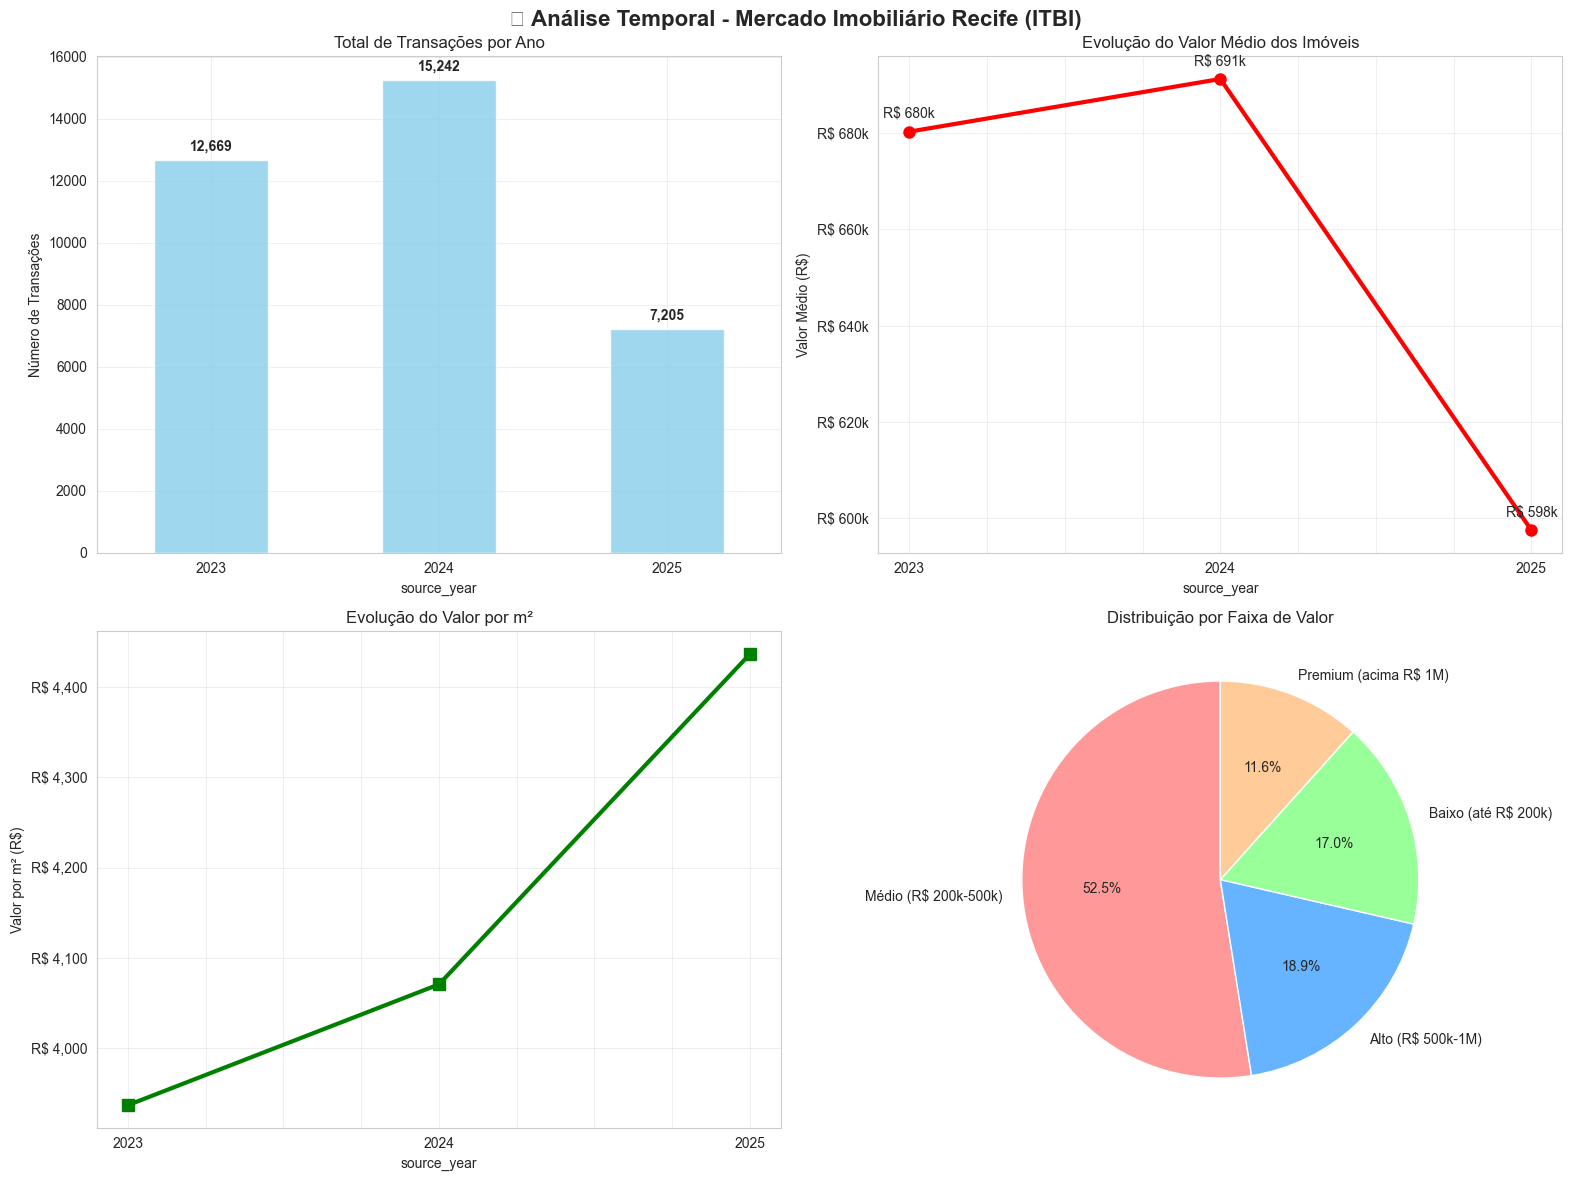


🔍 INSIGHTS DA ANÁLISE TEMPORAL:
-----------------------------------
💰 Crescimento do valor médio (2023-2025): -12.2%
📊 Crescimento das transações: -43.1%
🏆 Ano mais ativo: 2024 (15,242 transações)
💎 Maior valor médio: 2024 (R$ 691,220.25)
🏘️ Valor por m² médio geral: R$ 4097.58
🎯 Faixa de valor predominante: Médio (R$ 200k-500k) (18,441 imóveis)
📅 Mês mais ativo: 5 (4727 transações)


In [21]:
# ============================================================================= 
# ANÁLISE 1: EVOLUÇÃO TEMPORAL DOS VALORES
# =============================================================================

print("\n📈 ANÁLISE 1: EVOLUÇÃO TEMPORAL DOS VALORES")
print("=" * 50)

# Análise por ano
yearly_analysis = df_analysis.groupby('source_year').agg({
    'valor_avaliacao': ['count', 'mean', 'median', 'std'],
    'valor_por_m2': 'mean',
    'tem_financiamento': 'mean'
}).round(2)

yearly_analysis.columns = [
    'total_transacoes', 'valor_medio', 'valor_mediano', 
    'desvio_padrao', 'valor_m2_medio', 'perc_financiamento'
]

# Análise mensal
monthly_analysis = df_analysis.groupby(['source_year', 'mes_transacao']).agg({
    'valor_avaliacao': ['count', 'mean']
}).round(2)

monthly_analysis.columns = ['transacoes_mes', 'valor_medio_mes']
monthly_analysis = monthly_analysis.reset_index()

# Criar visualização temporal
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📈 Análise Temporal - Mercado Imobiliário Recife (ITBI)', fontsize=16, fontweight='bold')

# Gráfico 1: Total de transações por ano
yearly_analysis['total_transacoes'].plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
ax1.set_title('Total de Transações por Ano')
ax1.set_ylabel('Número de Transações')
ax1.tick_params(axis='x', rotation=0)
ax1.grid(True, alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(yearly_analysis['total_transacoes']):
    ax1.text(i, v + 200, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Evolução do valor médio
yearly_analysis['valor_medio'].plot(kind='line', ax=ax2, marker='o', color='red', linewidth=3, markersize=8)
ax2.set_title('Evolução do Valor Médio dos Imóveis')
ax2.set_ylabel('Valor Médio (R$)')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}k'))
ax2.grid(True, alpha=0.3)

# Adicionar valores nos pontos
for i, (year, value) in enumerate(yearly_analysis['valor_medio'].items()):
    ax2.annotate(f'R$ {value/1000:.0f}k', (i, value), textcoords="offset points", xytext=(0,10), ha='center')

# Gráfico 3: Evolução do valor por m²
yearly_analysis['valor_m2_medio'].plot(kind='line', ax=ax3, marker='s', color='green', linewidth=3, markersize=8)
ax3.set_title('Evolução do Valor por m²')
ax3.set_ylabel('Valor por m² (R$)')
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x:,.0f}'))
ax3.grid(True, alpha=0.3)

# Gráfico 4: Distribuição por faixa de valor
faixa_dist = df_analysis['faixa_valor'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
faixa_dist.plot(kind='pie', ax=ax4, autopct='%1.1f%%', startangle=90, colors=colors)
ax4.set_title('Distribuição por Faixa de Valor')
ax4.set_ylabel('')

plt.tight_layout()
plt.show()

# Calcular insights da análise temporal
print("\n🔍 INSIGHTS DA ANÁLISE TEMPORAL:")
print("-" * 35)

# Crescimento entre anos
years = sorted(yearly_analysis.index)
if len(years) > 1:
    growth_valor = ((yearly_analysis.loc[years[-1], 'valor_medio'] - yearly_analysis.loc[years[0], 'valor_medio']) / yearly_analysis.loc[years[0], 'valor_medio']) * 100
    growth_transacoes = ((yearly_analysis.loc[years[-1], 'total_transacoes'] - yearly_analysis.loc[years[0], 'total_transacoes']) / yearly_analysis.loc[years[0], 'total_transacoes']) * 100
    
    print(f"💰 Crescimento do valor médio ({years[0]}-{years[-1]}): {growth_valor:+.1f}%")
    print(f"📊 Crescimento das transações: {growth_transacoes:+.1f}%")

print(f"🏆 Ano mais ativo: {yearly_analysis['total_transacoes'].idxmax()} ({yearly_analysis['total_transacoes'].max():,} transações)")
print(f"💎 Maior valor médio: {yearly_analysis['valor_medio'].idxmax()} (R$ {yearly_analysis['valor_medio'].max():,.2f})")
print(f"🏘️ Valor por m² médio geral: R$ {df_analysis['valor_por_m2'].mean():.2f}")
print(f"🎯 Faixa de valor predominante: {faixa_dist.index[0]} ({faixa_dist.iloc[0]:,} imóveis)")

# Sazonalidade
sazonalidade = df_analysis.groupby('mes_transacao')['valor_avaliacao'].count()
mes_mais_ativo = sazonalidade.idxmax()
print(f"📅 Mês mais ativo: {mes_mais_ativo} ({sazonalidade.max()} transações)")


🏘️ ANÁLISE 2: ANÁLISE GEOGRÁFICA POR BAIRROS


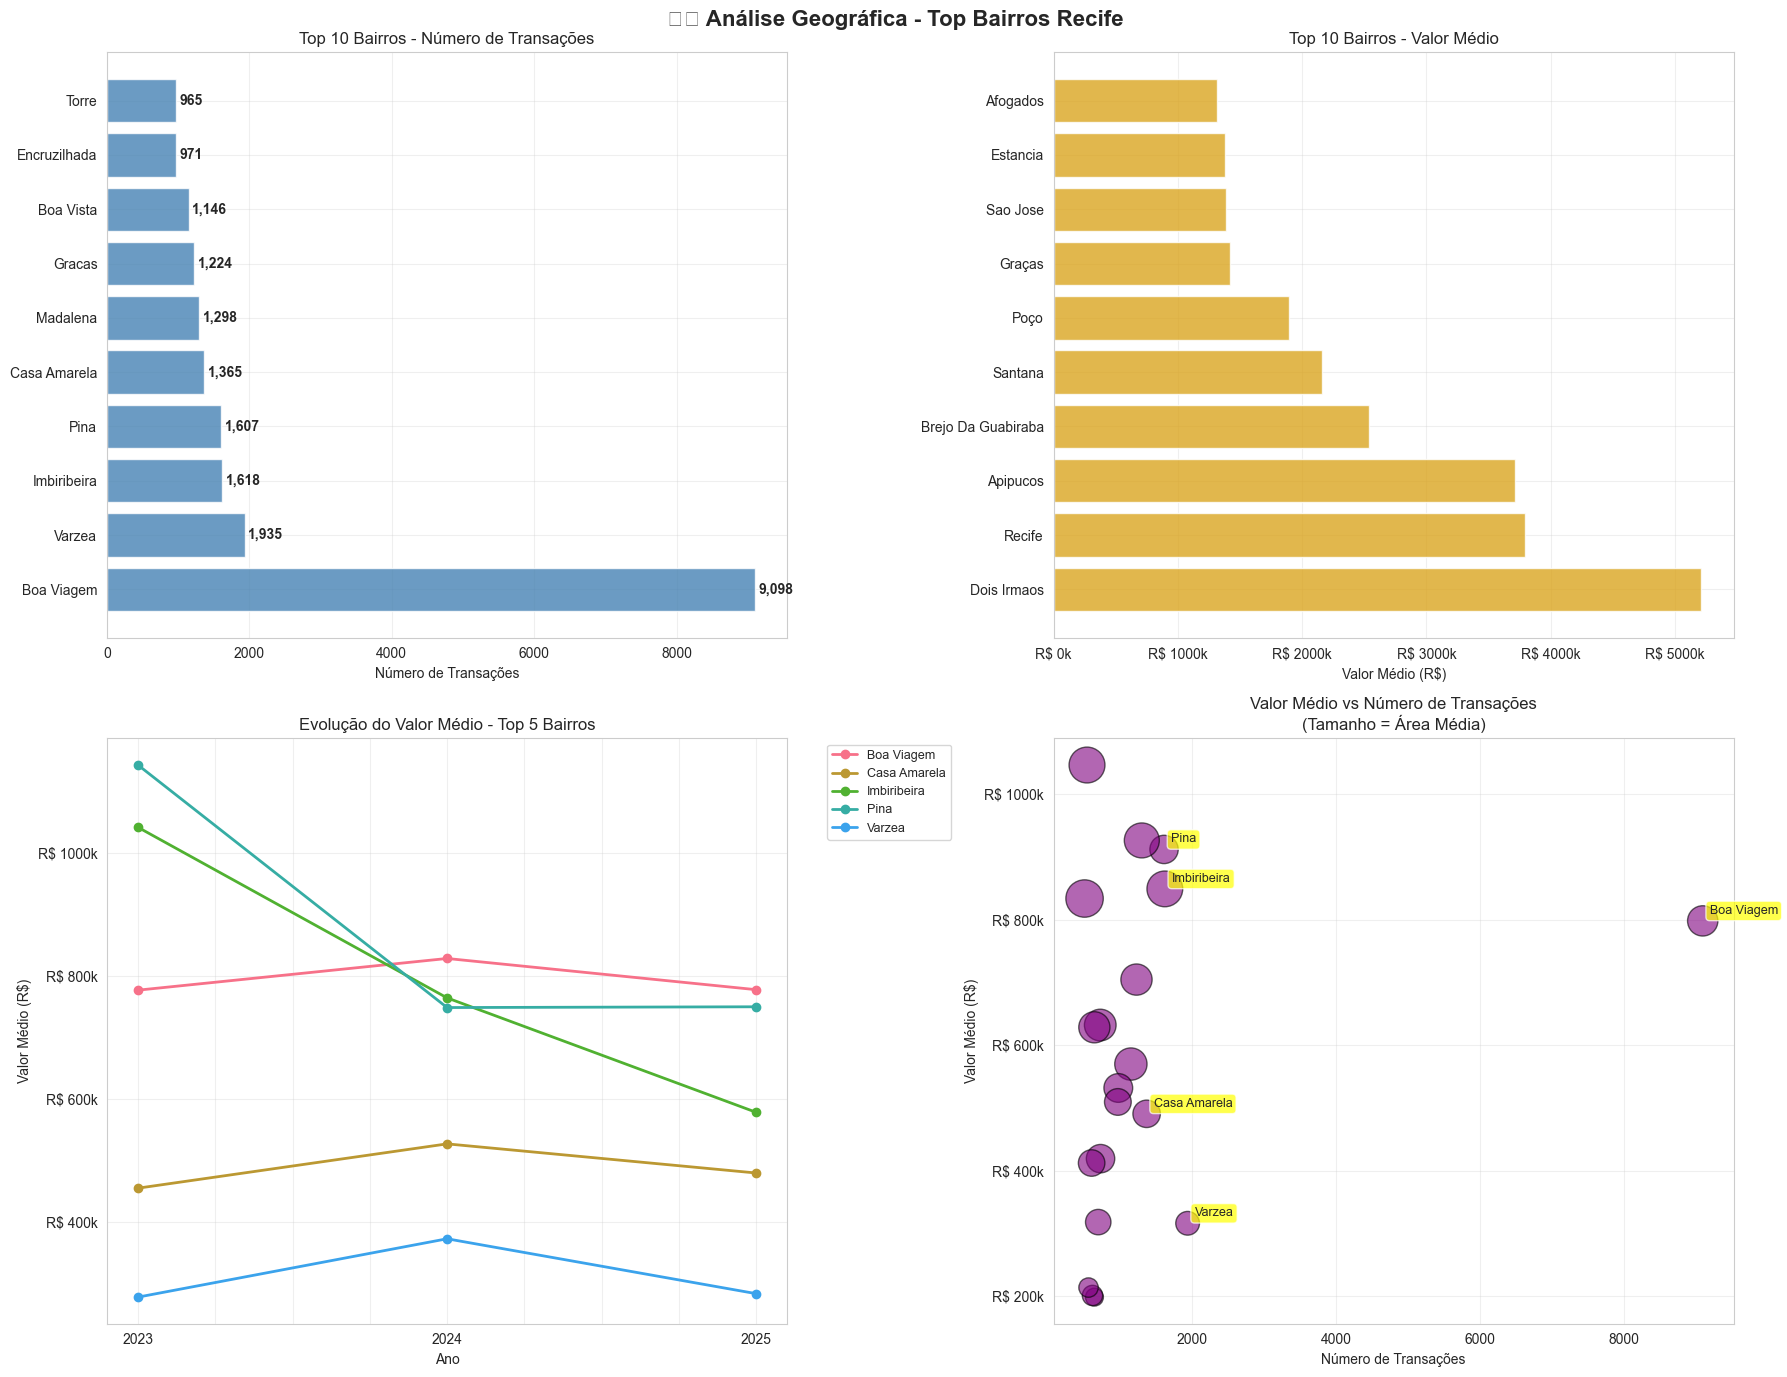


🔍 INSIGHTS DA ANÁLISE GEOGRÁFICA:
----------------------------------------
🏘️ Total de bairros com transações: 98
🏆 Bairro mais ativo: Boa Viagem (9,098 transações)
💎 Bairro mais valorizado: Dois Irmaos (R$ 5,210,910.67)
📊 Concentração top 5 bairros: 44.5% das transações
📈 Concentração top 10 bairros: 60.4% das transações
🏢 Maior valor por m²: Dois Irmaos (R$ 40,474.12/m²)

📋 TOP 10 BAIRROS - RESUMO:
      bairro  total_transacoes   valor_medio valor_m2_medio
  Boa Viagem              9098 R$ 798,127.93    R$ 4,692.29
      Varzea              1935 R$ 316,550.47    R$ 3,467.37
 Imbiribeira              1618 R$ 849,097.56    R$ 3,730.32
        Pina              1607 R$ 911,916.26    R$ 5,289.26
Casa Amarela              1365 R$ 490,891.32    R$ 3,850.70
    Madalena              1298 R$ 926,256.41    R$ 3,985.15
      Gracas              1224 R$ 704,662.35    R$ 3,862.40
   Boa Vista              1146 R$ 570,130.67    R$ 3,835.15
Encruzilhada               971 R$ 532,054.68    R$ 3,81

In [22]:
# ============================================================================= 
# ANÁLISE 2: ANÁLISE GEOGRÁFICA POR BAIRROS
# =============================================================================

print("\n🏘️ ANÁLISE 2: ANÁLISE GEOGRÁFICA POR BAIRROS")
print("=" * 50)

# Análise por bairros
bairro_analysis = df_analysis.groupby('bairro').agg({
    'valor_avaliacao': ['count', 'mean', 'median', 'std'],
    'valor_por_m2': ['mean', 'median'],
    'area_construida': 'mean',
    'tem_financiamento': 'mean'
}).round(2)

bairro_analysis.columns = [
    'total_transacoes', 'valor_medio', 'valor_mediano', 'desvio_padrao',
    'valor_m2_medio', 'valor_m2_mediano', 'area_media', 'perc_financiamento'
]

bairro_analysis = bairro_analysis.reset_index().sort_values('total_transacoes', ascending=False)

# Top 20 bairros
top_bairros = bairro_analysis.head(20)

# Evolução por bairro ao longo do tempo (top 5)
top_5_bairros = top_bairros.head(5)['bairro'].tolist()

evolucao_bairros = df_analysis[df_analysis['bairro'].isin(top_5_bairros)].groupby(
    ['bairro', 'source_year']
)['valor_avaliacao'].mean().unstack(fill_value=0)

# Visualizações por bairros
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('🏘️ Análise Geográfica - Top Bairros Recife', fontsize=16, fontweight='bold')

# Gráfico 1: Top 10 bairros por número de transações
top_10_trans = top_bairros.head(10)
ax1.barh(range(len(top_10_trans)), top_10_trans['total_transacoes'], color='steelblue', alpha=0.8)
ax1.set_yticks(range(len(top_10_trans)))
ax1.set_yticklabels(top_10_trans['bairro'], fontsize=10)
ax1.set_title('Top 10 Bairros - Número de Transações')
ax1.set_xlabel('Número de Transações')
ax1.grid(True, alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(top_10_trans['total_transacoes']):
    ax1.text(v + 50, i, f'{v:,}', va='center', ha='left', fontweight='bold')

# Gráfico 2: Top 10 bairros por valor médio
top_10_valor = bairro_analysis.nlargest(10, 'valor_medio')
ax2.barh(range(len(top_10_valor)), top_10_valor['valor_medio'], color='goldenrod', alpha=0.8)
ax2.set_yticks(range(len(top_10_valor)))
ax2.set_yticklabels(top_10_valor['bairro'], fontsize=10)
ax2.set_title('Top 10 Bairros - Valor Médio')
ax2.set_xlabel('Valor Médio (R$)')
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}k'))
ax2.grid(True, alpha=0.3)

# Gráfico 3: Evolução dos top 5 bairros
if not evolucao_bairros.empty:
    evolucao_bairros.T.plot(kind='line', ax=ax3, marker='o', linewidth=2, markersize=6)
    ax3.set_title('Evolução do Valor Médio - Top 5 Bairros')
    ax3.set_ylabel('Valor Médio (R$)')
    ax3.set_xlabel('Ano')
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}k'))
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax3.grid(True, alpha=0.3)

# Gráfico 4: Scatter valor médio vs número de transações
scatter = ax4.scatter(top_bairros['total_transacoes'], top_bairros['valor_medio'], 
           s=top_bairros['area_media']*3, alpha=0.6, color='purple', edgecolors='black')
ax4.set_title('Valor Médio vs Número de Transações\n(Tamanho = Área Média)')
ax4.set_xlabel('Número de Transações')
ax4.set_ylabel('Valor Médio (R$)')
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}k'))
ax4.grid(True, alpha=0.3)

# Adicionar rótulos aos principais pontos
for i, row in top_bairros.head(5).iterrows():
    ax4.annotate(row['bairro'], (row['total_transacoes'], row['valor_medio']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

# Calcular índices de concentração
total_transacoes = bairro_analysis['total_transacoes'].sum()
concentracao_top5 = top_bairros.head(5)['total_transacoes'].sum() / total_transacoes * 100
concentracao_top10 = top_bairros.head(10)['total_transacoes'].sum() / total_transacoes * 100

print("\n🔍 INSIGHTS DA ANÁLISE GEOGRÁFICA:")
print("-" * 40)
print(f"🏘️ Total de bairros com transações: {len(bairro_analysis)}")
print(f"🏆 Bairro mais ativo: {top_bairros.iloc[0]['bairro']} ({top_bairros.iloc[0]['total_transacoes']:,} transações)")
print(f"💎 Bairro mais valorizado: {top_10_valor.iloc[0]['bairro']} (R$ {top_10_valor.iloc[0]['valor_medio']:,.2f})")
print(f"📊 Concentração top 5 bairros: {concentracao_top5:.1f}% das transações")
print(f"📈 Concentração top 10 bairros: {concentracao_top10:.1f}% das transações")

# Top bairros por valor por m²
top_10_m2 = bairro_analysis.nlargest(10, 'valor_m2_medio')
print(f"🏢 Maior valor por m²: {top_10_m2.iloc[0]['bairro']} (R$ {top_10_m2.iloc[0]['valor_m2_medio']:,.2f}/m²)")

# Mostrar tabela dos top bairros
print(f"\n📋 TOP 10 BAIRROS - RESUMO:")
print("=" * 80)
display_cols = ['bairro', 'total_transacoes', 'valor_medio', 'valor_m2_medio']
top_10_display = top_bairros[display_cols].head(10).copy()
top_10_display['valor_medio'] = top_10_display['valor_medio'].apply(lambda x: f'R$ {x:,.2f}')
top_10_display['valor_m2_medio'] = top_10_display['valor_m2_medio'].apply(lambda x: f'R$ {x:,.2f}')
print(top_10_display.to_string(index=False))


🏢 ANÁLISE 3: SEGMENTAÇÃO POR TIPO E CARACTERÍSTICAS


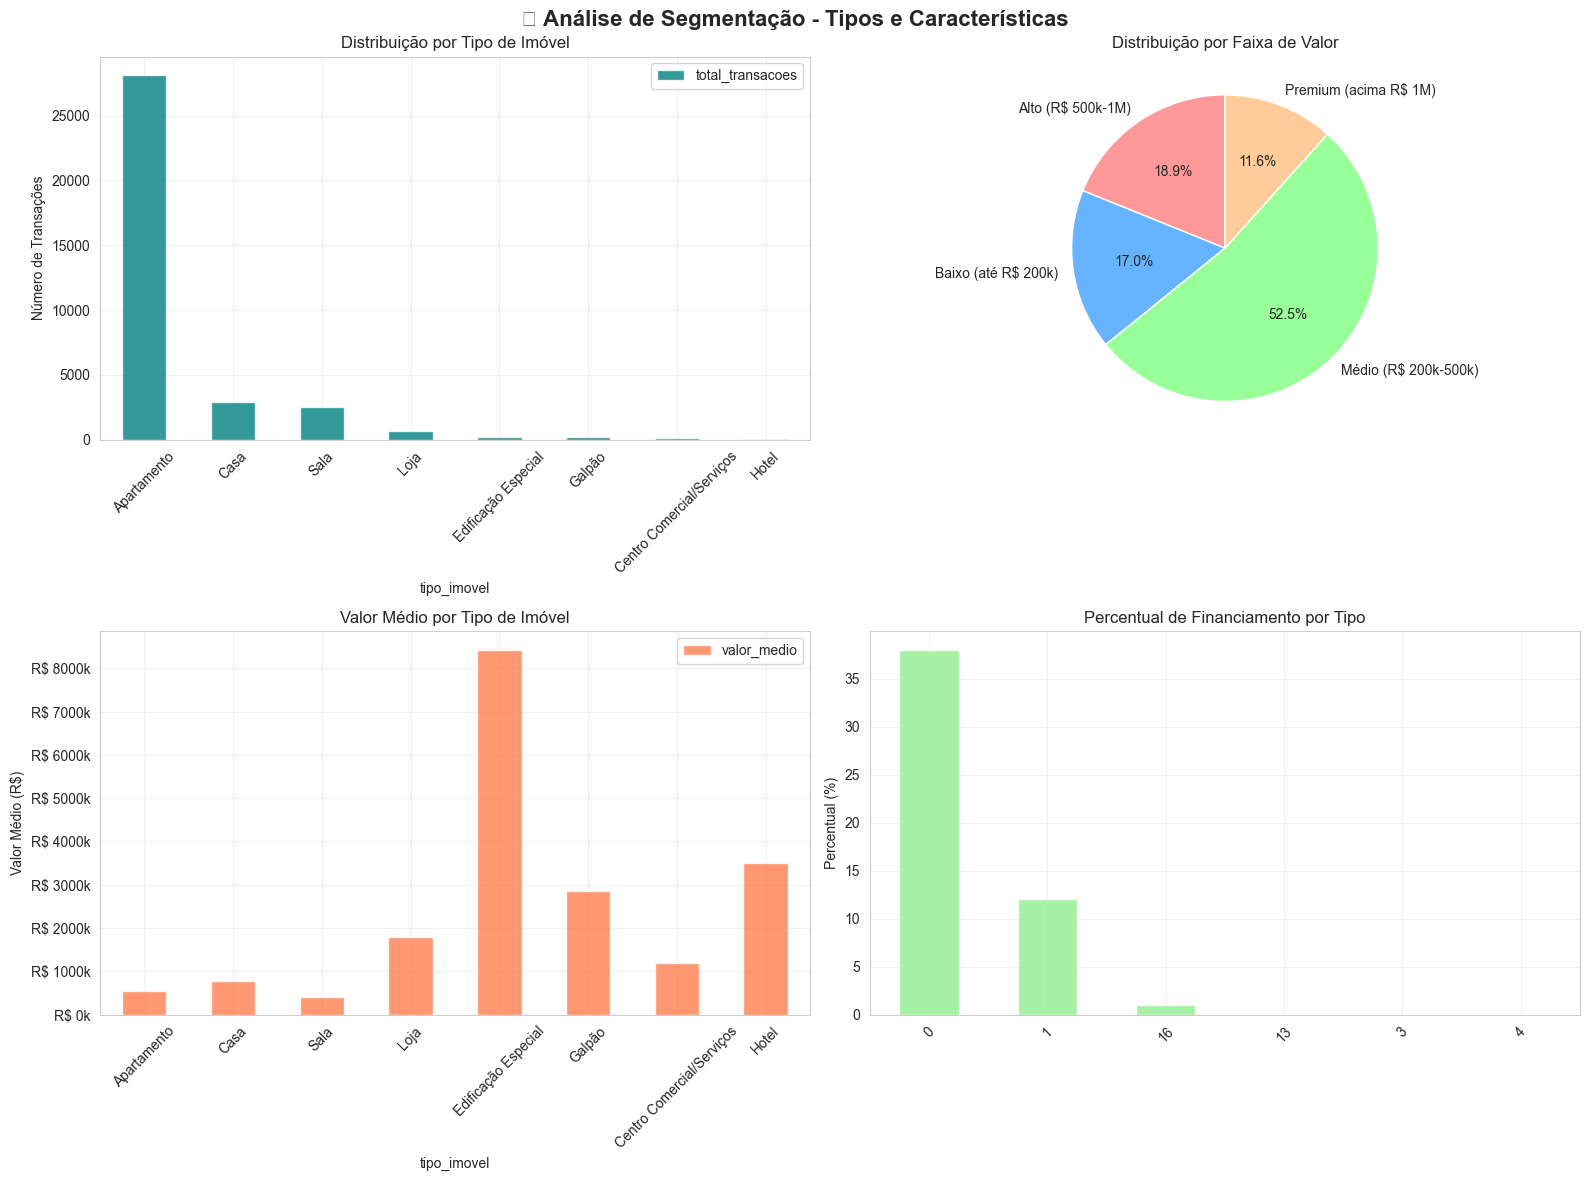


📊 MATRIZ DE CORRELAÇÃO:
------------------------------


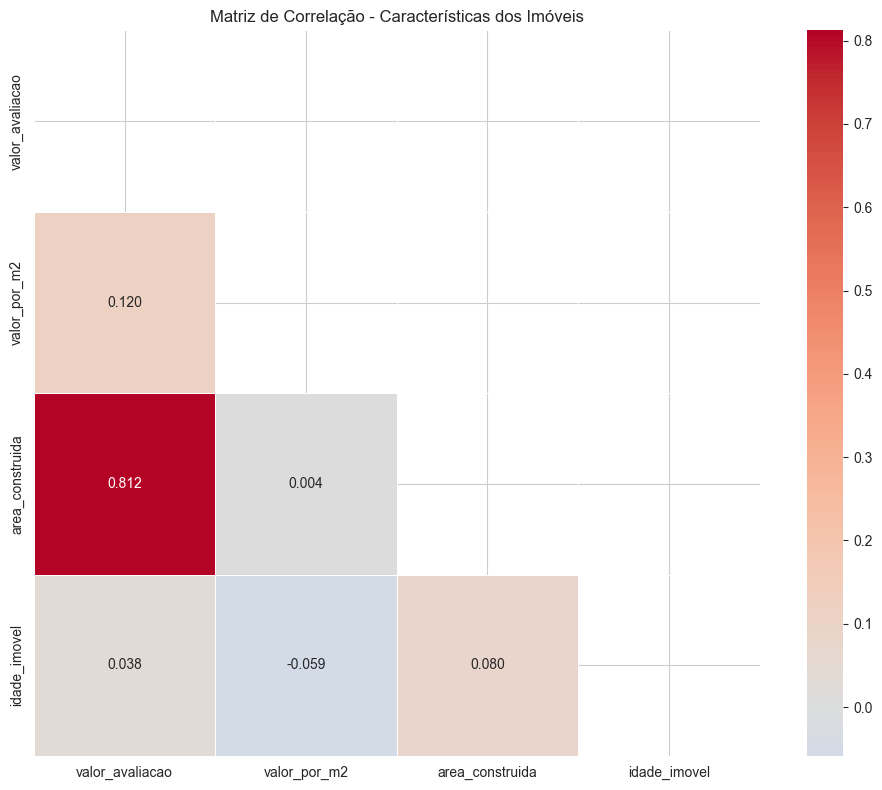


🔍 INSIGHTS DA ANÁLISE DE SEGMENTAÇÃO:
---------------------------------------------
🏢 Tipo mais comum: Apartamento (28,142 transações)
💎 Tipo mais valorizado: Instituição Educacional (R$ 8,908,321.21)
💰 Faixa de valor predominante: Médio (R$ 200k-500k) (52.5%)
💳 Percentual geral com financiamento: 31.7%
📐 Correlação valor vs área: 0.812
⏰ Correlação valor vs idade: 0.038
🏗️ Total de tipos de imóveis: 19

📋 TOP 5 TIPOS DE IMÓVEIS - RESUMO:
        tipo_imovel  total_transacoes  valor_medio  perc_financiamento
        Apartamento             28142    542856.22                0.38
               Casa              2907    777795.75                0.12
               Sala              2558    399327.77                0.01
               Loja               668   1804145.10                0.00
Edificação Especial               248   8428154.66                0.00


In [24]:
# Importar numpy que estava faltando
import numpy as np

# ============================================================================= 
# ANÁLISE 3: SEGMENTAÇÃO POR TIPO E CARACTERÍSTICAS
# =============================================================================

print("\n🏢 ANÁLISE 3: SEGMENTAÇÃO POR TIPO E CARACTERÍSTICAS")
print("=" * 60)

# Análise por tipo de imóvel
tipo_analysis = df_analysis.groupby('tipo_imovel').agg({
    'valor_avaliacao': ['count', 'mean', 'median'],
    'valor_por_m2': 'mean',
    'area_construida': 'mean',
    'tem_financiamento': 'mean',
    'idade_imovel': 'mean'
}).round(2)

tipo_analysis.columns = [
    'total_transacoes', 'valor_medio', 'valor_mediano',
    'valor_m2_medio', 'area_media', 'perc_financiamento', 'idade_media'
]

tipo_analysis = tipo_analysis.reset_index().sort_values('total_transacoes', ascending=False)

# Análise por faixa de valor
faixa_analysis = df_analysis.groupby('faixa_valor').agg({
    'valor_avaliacao': 'count',
    'tem_financiamento': 'mean',
    'area_construida': 'mean'
}).round(2)

faixa_analysis.columns = ['total_transacoes', 'perc_financiamento', 'area_media']

# Visualizações
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🏢 Análise de Segmentação - Tipos e Características', fontsize=16, fontweight='bold')

# Gráfico 1: Distribuição por tipo de imóvel
top_tipos = tipo_analysis.head(8)
top_tipos.plot(x='tipo_imovel', y='total_transacoes', kind='bar', ax=ax1, color='teal', alpha=0.8)
ax1.set_title('Distribuição por Tipo de Imóvel')
ax1.set_ylabel('Número de Transações')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Gráfico 2: Distribuição por faixa de valor
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
faixa_analysis['total_transacoes'].plot(kind='pie', ax=ax2, autopct='%1.1f%%', 
                                       startangle=90, colors=colors)
ax2.set_title('Distribuição por Faixa de Valor')
ax2.set_ylabel('')

# Gráfico 3: Valor médio por tipo de imóvel
top_tipos.plot(x='tipo_imovel', y='valor_medio', kind='bar', ax=ax3, color='coral', alpha=0.8)
ax3.set_title('Valor Médio por Tipo de Imóvel')
ax3.set_ylabel('Valor Médio (R$)')
ax3.tick_params(axis='x', rotation=45)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}k'))
ax3.grid(True, alpha=0.3)

# Gráfico 4: Percentual de financiamento por tipo
top_tipos_financ = top_tipos.head(6)
(top_tipos_financ['perc_financiamento'] * 100).plot(kind='bar', ax=ax4, color='lightgreen', alpha=0.8)
ax4.set_title('Percentual de Financiamento por Tipo')
ax4.set_ylabel('Percentual (%)')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análise de correlação
print("\n📊 MATRIZ DE CORRELAÇÃO:")
print("-" * 30)

numeric_cols = ['valor_avaliacao', 'valor_por_m2', 'area_construida', 'idade_imovel']
# Filtrar apenas colunas que existem e têm dados numéricos
available_numeric_cols = []
for col in numeric_cols:
    if col in df_analysis.columns and df_analysis[col].notna().sum() > 100:
        available_numeric_cols.append(col)

if len(available_numeric_cols) >= 2:
    correlation_matrix = df_analysis[available_numeric_cols].corr()
    
    # Mostrar matriz de correlação
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
               square=True, linewidths=0.5, mask=mask, fmt='.3f')
    plt.title('Matriz de Correlação - Características dos Imóveis')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Dados insuficientes para matriz de correlação")
    correlation_matrix = pd.DataFrame()

# Insights da análise de segmentação
print("\n🔍 INSIGHTS DA ANÁLISE DE SEGMENTAÇÃO:")
print("-" * 45)

print(f"🏢 Tipo mais comum: {tipo_analysis.iloc[0]['tipo_imovel']} ({tipo_analysis.iloc[0]['total_transacoes']:,} transações)")
tipo_mais_valorizado = tipo_analysis.nlargest(1, 'valor_medio').iloc[0]
print(f"💎 Tipo mais valorizado: {tipo_mais_valorizado['tipo_imovel']} (R$ {tipo_mais_valorizado['valor_medio']:,.2f})")

faixa_predominante = faixa_analysis['total_transacoes'].idxmax()
perc_faixa = (faixa_analysis.loc[faixa_predominante, 'total_transacoes'] / faixa_analysis['total_transacoes'].sum()) * 100
print(f"💰 Faixa de valor predominante: {faixa_predominante} ({perc_faixa:.1f}%)")

# Estatísticas de financiamento
total_com_financiamento = df_analysis['tem_financiamento'].sum()
total_transacoes = len(df_analysis)
perc_financiamento_geral = (total_com_financiamento / total_transacoes) * 100
print(f"💳 Percentual geral com financiamento: {perc_financiamento_geral:.1f}%")

if len(available_numeric_cols) >= 2 and 'valor_avaliacao' in correlation_matrix.columns:
    if 'area_construida' in correlation_matrix.columns:
        corr_valor_area = correlation_matrix.loc['valor_avaliacao', 'area_construida']
        print(f"📐 Correlação valor vs área: {corr_valor_area:.3f}")
    
    if 'idade_imovel' in correlation_matrix.columns:
        corr_valor_idade = correlation_matrix.loc['valor_avaliacao', 'idade_imovel']
        print(f"⏰ Correlação valor vs idade: {corr_valor_idade:.3f}")

print(f"🏗️ Total de tipos de imóveis: {len(tipo_analysis)}")

# Mostrar tabela resumo
print("\n📋 TOP 5 TIPOS DE IMÓVEIS - RESUMO:")
display_cols = ['tipo_imovel', 'total_transacoes', 'valor_medio', 'perc_financiamento']
print(tipo_analysis[display_cols].head(5).to_string(index=False, float_format='%.2f'))